In [1]:
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
from kret_notebook import *  # NOTE import first
from kret_lgbm._core.lgbm_nb_imports import *
from kret_lightning._core.lightning_nb_imports import *
from kret_matplotlib._core.mpl_nb_imports import *
from kret_np_pd._core.np_pd_nb_imports import *
from kret_optuna._core.optuna_nb_imports import *
from kret_polars._core.polars_nb_imports import *
from kret_rosetta._core.rosetta_nb_imports import *
from kret_sklearn._core.sklearn_nb_imports import *
from kret_torch_utils._core.torch_nb_imports import *
from kret_tqdm._core.tqdm_nb_imports import *
from kret_type_hints._core.types_nb_imports import *
from kret_utils._core.utils_nb_imports import *

# from kret_wandb._core.wandb_nb_imports import *  # NOTE this is slow to import

Loaded environment variables from /Users/Akseldkw/coding/projects_kretsinger/.env
[kret_lgbm._core.lgbm_nb_imports] Imported kret_lgbm._core.lgbm_nb_imports in 2.1840 seconds
[kret_lightning._core.lightning_nb_imports] Imported kret_lightning._core.lightning_nb_imports in 4.1168 seconds
[kret_matplotlib._core.mpl_nb_imports] Imported kret_matplotlib._core.mpl_nb_imports in 0.2776 seconds
[kret_np_pd._core.np_pd_nb_imports] Imported kret_np_pd._core.np_pd_nb_imports in 0.0007 seconds
[kret_optuna._core.optuna_nb_imports] Imported kret_optuna._core.optuna_nb_imports in 0.0007 seconds
[kret_polars._core.polars_nb_imports] Imported kret_polars._core.polars_nb_imports in 0.0794 seconds
[kret_rosetta._core.rosetta_nb_imports] Imported kret_rosetta._core.rosetta_nb_imports in 0.0000 seconds
[kret_sklearn._core.sklearn_nb_imports] Imported kret_sklearn._core.sklearn_nb_imports in 0.1775 seconds
[kret_torch_utils._core.torch_nb_imports] Imported kret_torch_utils._core.torch_nb_imports in 0.3738

In [ ]:
# from projects.heart_nn_loader import HeartNNLoader
# from projects.heart_nn import HeartFailureNN

from projects.heart_failure.heart_nn_loader import HeartNNLoader
from projects.heart_failure.heart_nn import HeartFailureNN

# Load Data

In [4]:
file_sub_path = "datasets/heart-failure-prediction/versions/1/heart.csv"
df_raw: pd.DataFrame = pd.read_csv(UKS_CONSTANTS.KAGGLEHUB_DIR / file_sub_path, **UKS_DEFAULTS.READ_CSV_PD_DEFAULT)

In [5]:
def load_and_clean(base_dir: Path = UKS_CONSTANTS.KAGGLEHUB_DIR, filename: str = file_sub_path):
    df_load = FunctionTransformer(func=pd.read_csv, validate=False, kw_args={})
    custom_cleanup = FunctionTransformer(func=UKS_NP_PD.data_cleanup, validate=False, kw_args={"ret": True})
    pipeline_load_and_clean = PipelinePD(
        steps=[
            ("df_load", df_load),
            ("cleanup_custom", custom_cleanup),
        ]
    )
    df = pipeline_load_and_clean.fit_transform_df(base_dir / filename)
    features, target = UKS_NP_PD.pop_label_and_drop(df, label_col="HeartDisease")
    x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)
    return x_train, x_val, y_train, y_val

In [6]:
x_train, x_val, y_train, y_val = load_and_clean()

In [7]:
dtt([x_train])

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
,int64,category,category,int64,int64,bool,category,int64,bool,float64,category
75,46,M,NAP,150,163,False,Normal,116,False,0.000,Up
681,51,M,ASY,140,261,False,LVH,186,True,0.000,Up
105,57,M,ATA,140,260,True,Normal,140,False,0.000,Up
381,50,M,ASY,115,0,False,Normal,120,True,0.500,Flat
36,65,M,ASY,140,306,True,Normal,87,True,1.500,Flat


## Custom Pandas Loader

In [8]:
float_cols = UKS_NP_PD.numeric_cols(x_train)
cat_cols = UKS_NP_PD.cat_cols(x_train)
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ordinal = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

column_transform = ColumnTransformer(
    transformers=[("scaler", power_transformer, float_cols), ("onehot", one_hot, cat_cols)],
    # transformers=[("scaler", power_transformer, float_cols), ("ordinal", ordinal, cat_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    verbose=True,
)
steps = [("column_transform", column_transform)]
pipeline_x = PipelinePD(steps=steps)

In [9]:
pipeline_y = PipelinePD([("identity", FunctionTransformer(lambda x: x))])

In [10]:
loader_heart = HeartNNLoader(UKS_CONSTANTS.KAGGLEHUB_DIR, pipeline_pd_xy=(pipeline_x, pipeline_y))

Saving hparams, ignoring ('pipeline_pd_xy',)


In [11]:
loader_heart.hparams_initial

"data_dir": /Users/Akseldkw/coding/data_kretsinger/kagglehub
"split":    None

In [12]:
_ = loader_heart.setup("fit")

Setting up data for stage: fit
Removed 0 rows, representing 0.00% of the data
[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ........ (2 of 2) Processing onehot, total=   0.0s
Setting up data for stage: validate
Removed 0 rows, representing 0.00% of the data


In [13]:
loader_heart.set_dataloader_args(batch_size=256, shuffle=True)

In [14]:
dtt([*loader_heart.x_y_processed])

Age 
 RestingBP 
 Cholesterol 
 MaxHR 
 Oldpeak 
 Sex_F 
 Sex_M 
 ChestPainType_ASY 
 ChestPainType_ATA 
 ChestPainType_NAP 
 ChestPainType_TA 
 FastingBS_False 
 FastingBS_True 
 RestingECG_LVH 
 RestingECG_Normal 
 RestingECG_ST 
 ExerciseAngina_False 
 ExerciseAngina_True 
 ST_Slope_Down 
 ST_Slope_Flat 
 ST_Slope_Up 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 
 
 
 
 343 
 -0.163 
 -0.141 
 -1.722 
 -0.537 
 -0.805 
 0.000 
 1.000 
 1.000 
 0.000 
 0.000 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 
 
 511 
 1.026 
 1.473 
 0.673 
 -1.805 
 1.142 
 0.000 
 1.000 
 1.000 
 0.000 
 0.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 
 
 615 
 1.815 
 -0.141 
 0.966 
 -0.975 
 1.420 
 0.000 
 1.000 
 1.000 
 0.000 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 
 
 698 
 -1.282 
 -0.141 
 0.366 
 1.406 
 1.142 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 
 
 866 
 -0.985 
 -0.141 
 0.396 
 2.226 
 -0.805 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 0.000 
 1.000 
 
 
 
 
 
 
 HeartDisease 
 
 
 
 bool 
 
 
 
 
 343 
 True 
 
 
 511 
 True 
 
 
 615 
 True 
 
 
 698 
 False 
 
 
 866 
 False

# Implementation

In [15]:
nn_new = HeartFailureNN()

Saving hparams, ignoring ['input_size']


In [16]:
TrainerDynamicDefaults.trainer_dynamic_defaults(nn_new, loader_heart, logtype=None)

{'logger': None,
 'default_root_dir': PosixPath('/Users/Akseldkw/coding/data_kretsinger/lightning_logs/HeartFailureNN/v_004'),
 'callbacks': []}

In [17]:
direction = "minimize"
topn_saver = TopNModelSaver(n=3, save_dir=nn_new.ckpt_path, direction=direction)

# Load & Evaluate Model

In [18]:
TopNModelSaver.filename_fmt.format(number=1, score=0.653)

'trial_0001_score_0.6530'

In [19]:
HeartFailureNN.classname

'HeartFailureNN'

In [20]:
HeartFailureNN().classname

Saving hparams, ignoring ['input_size']


'HeartFailureNN'

In [21]:
nn = HeartFailureNN.load_from_checkpoint_custom()

Loading best checkpoint from /Users/Akseldkw/coding/data_kretsinger/lightning_logs/HeartFailureNN/v_004/trial_0003_score_0.4334.ckpt with hparams from /Users/Akseldkw/coding/data_kretsinger/lightning_logs/HeartFailureNN/v_004/trial_0003_score_0.4334.hparams.yaml
Saving hparams, ignoring ['input_size']


In [22]:
dtt([x_val, y_val])

Age 
 Sex 
 ChestPainType 
 RestingBP 
 Cholesterol 
 FastingBS 
 RestingECG 
 MaxHR 
 ExerciseAngina 
 Oldpeak 
 ST_Slope 
 
 
 
 int64 
 category 
 category 
 int64 
 int64 
 bool 
 category 
 int64 
 bool 
 float64 
 category 
 
 
 
 
 142 
 47 
 M 
 ASY 
 160 
 291 
 False 
 ST 
 158 
 True 
 3.000 
 Flat 
 
 
 415 
 66 
 F 
 ASY 
 155 
 0 
 True 
 Normal 
 90 
 False 
 0.000 
 Flat 
 
 
 251 
 48 
 M 
 ASY 
 120 
 260 
 False 
 Normal 
 115 
 False 
 2.000 
 Flat 
 
 
 500 
 65 
 M 
 ASY 
 136 
 248 
 False 
 Normal 
 140 
 True 
 4.000 
 Down 
 
 
 308 
 58 
 M 
 ASY 
 115 
 0 
 True 
 Normal 
 138 
 False 
 0.500 
 Up 
 
 
 
 
 
 
 0 
 
 
 
 bool 
 
 
 
 
 26 
 True 
 
 
 44 
 True 
 
 
 71 
 True 
 
 
 88 
 True 
 
 
 94 
 True

In [23]:
x_val.shape

(138, 11)

In [24]:
loader_heart._val.tensors[1].device

device(type='mps', index=0)

In [26]:
x_val_tensor = loader_heart._val.tensors[0]

In [27]:
y_val = loader_heart._val.tensors[1]

In [ ]:
nn.eval()
with torch.no_grad():
    preds = nn.predict_step((x_val_tensor,), batch_idx=0)

/Users/Akseldkw/coding/kretsinger/kret_lightning/mixin_metrics.py:227: Applying sigmoid to logits for metric computation


In [29]:
(preds == y_val).sum()

tensor(145, device='mps:0')

In [ ]:
from torchmetrics import ConfusionMatrix


cmmx = ConfusionMatrix(task="binary", threshold=0.5).to(UKS_CONSTANTS.DEVICE_TORCH_STR)

In [34]:
cmmx(preds, y_val)

tensor([[78, 19],
        [19, 67]], device='mps:0')

In [36]:
cf = confusion_matrix(y_val.numpy(force=True), preds.numpy(force=True))

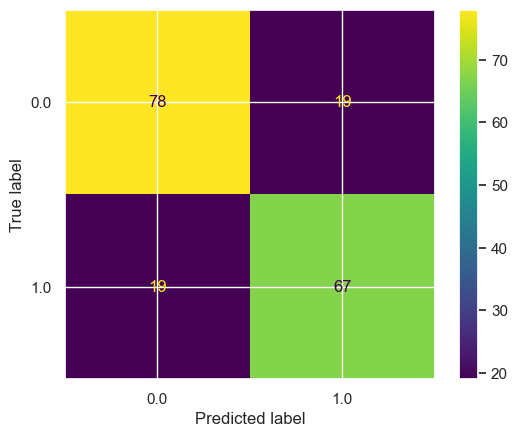

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val.cpu(), preds.cpu())

In [ ]:
from kret_sklearn.classification_eval import ClassificationEvalUtils, BinaryEvalResult

In [53]:
out = ClassificationEvalUtils.binary_eval(y_val.numpy(force=True), preds.numpy(force=True))

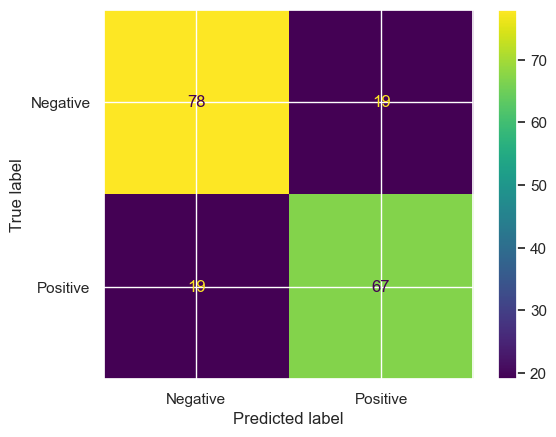

In [54]:
out.confusion_heatmap()

In [49]:
out.confusion_matrix

Predicted,Negative,Positive
Actual,,
Negative,78,19
Positive,19,67
